=== ToxicBERT Evaluation ===
              precision    recall  f1-score   support

        mild     0.5556    0.5000    0.5263        10
        safe     0.5714    0.6667    0.6154         6
      severe     0.6667    0.3333    0.4444         6
       toxic     0.4615    0.6000    0.5217        10

    accuracy                         0.5312        32
   macro avg     0.5638    0.5250    0.5270        32
weighted avg     0.5500    0.5312    0.5262        32



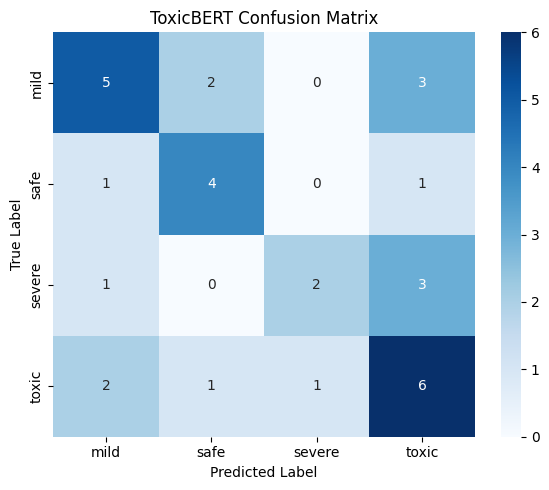

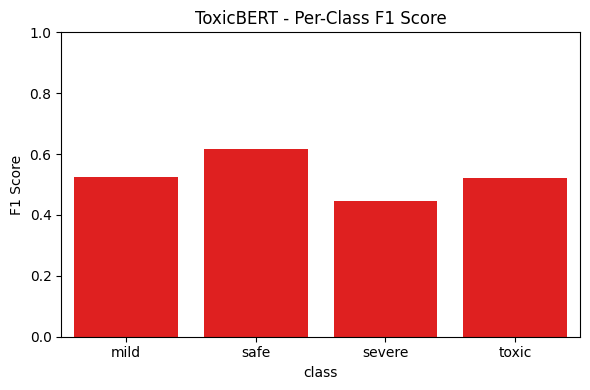


Metrics saved to ../results/metrics/phase3_toxicBert_metrics_all_round_comments.json


In [3]:
# =============================
# 03. ToxicBERT Experiments
# =============================

import os
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import joblib
import json

# ===================================
# Paths
# ===================================
DATA_PATH = "../data/test/all_round_comments_with_labels.csv"
MODEL_PATH = "../models/saved/toxic_bert"

# ===================================
# Load Data
# ===================================
df = pd.read_csv(DATA_PATH)
X = df["cleaned_comment"].tolist()
y = df["expected_label"].tolist()

# ===================================
# Load Fine-Tuned ToxicBERT Model
# ===================================
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(os.path.join(MODEL_PATH, "checkpoint-48000"))
model.eval()

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

# ===================================
# Load Label Mappings
# ===================================
id2label = joblib.load(os.path.join(MODEL_PATH, "id2labelToxicBERT.pkl"))
label2id = joblib.load(os.path.join(MODEL_PATH, "label2idToxicBERT.pkl"))

class_names = [id2label[i] for i in range(len(id2label))]
num_labels = len(class_names)

# ===================================
# Tokenize and Predict in Batches
# ===================================
batch_size = 16
preds = []
true_labels = []

for i in range(0, len(X), batch_size):
    batch_texts = X[i:i + batch_size]
    batch_labels = y[i:i + batch_size]
    
    encodings = tokenizer(batch_texts, truncation=True, padding=True, max_length=256, return_tensors="pt").to(device)
    
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=1).cpu().numpy()
        preds.extend(predictions)
        true_labels.extend(batch_labels)

# ===================================
# Decode Predictions
# ===================================
y_pred = [id2label[p] for p in preds]

# ===================================
# Classification Report
# ===================================
print("=== ToxicBERT Evaluation ===")
print(classification_report(true_labels, y_pred, target_names=class_names, digits=4))

# ===================================
# Confusion Matrix
# ===================================
cm = confusion_matrix(true_labels, y_pred, labels=class_names)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("ToxicBERT Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# ===================================
# Per-Class F1 Visualization
# ===================================
report = classification_report(true_labels, y_pred, target_names=class_names, output_dict=True)
f1_scores = [report[label]['f1-score'] for label in class_names]

df_f1 = pd.DataFrame({
    "class": class_names,
    "f1_score": f1_scores
})

plt.figure(figsize=(6, 4))
sns.barplot(data=df_f1, x="class", y="f1_score", color="red")
plt.title("ToxicBERT - Per-Class F1 Score")
plt.ylabel("F1 Score")
plt.ylim(0, 1)
plt.tight_layout()
plt.show()

# ===================================
# Save Metrics
# ===================================
results_dir = "../results/metrics"
os.makedirs(results_dir, exist_ok=True)

results = {
    "model": "ToxicBERT",
    "accuracy": np.mean(np.array(true_labels) == np.array(y_pred)),
    "macro_f1": np.mean(f1_scores),
    "per_class_f1": {label: float(report[label]['f1-score']) for label in class_names}
}

metrics_path = os.path.join(results_dir, "phase3_toxicBert_metrics_all_round_comments.json")
with open(metrics_path, "w") as f:
    json.dump(results, f, indent=4)

print(f"\nMetrics saved to {metrics_path}")